In [704]:
import os
import requests
import json
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

from dataanalyser import DataAnalyser
from simulationanalyser import SimulationAnalyser

# General

**Standaard voor elk project**  
- profiel elektriciteitsvraag (indien meer assets dan laadpalen en warmtepomp, dwz voor assets die we niet controleren)
- profiel zonne-instraling
- profiel elektriciteitsprijs

**Bijkomend indien warmte**  
- profiel warmtevraag
- Indien variabele warmtebronnen: profiel van warmteaanbod
- Indien warmtepomp op basis van buffer: profiel van input debiet naar buffer

**Bijkomend indien EV**
Voor EV load profiles is, als ik het model van Imec goed lees, het volgende nodig:
- profiel voor arrival times, duration times and total energy charged van laadsessies (input voor machine learning model van Imec: http://users.atlantis.ugent.be/cdvelder/papers/2020/lahariya2020energies.pdf
and https://github.com/mlahariya/EV-SDG)

**Projectspecifieke parameters**
- parameter range voor batterij (capaciteit, max op/ontlaadvermogen…)
- parameter range voor PV installatie (oriëntatie, inclinatie, type zonnepanelen, aantal panelen…)
- parameter range voor warmtepomp (capaciteit, compressietrappen, COP-waarden…)
- Indien warmtepomp op basis van buffer: parameter range voor buffer ((max/min)volume, max/min debieten…)
- Inschatting investeringskost voor assets (bvb battery of PV per kWh...)

**Output**  
Voor elk gelopen scenario:
- CAPEX en OPEX
- Percentages eigen verbruik en zelf-voorzienendheid (opgesplitst per energiebron, voor elektriciteit en warmte)


# Description: Technicum

**First Phase**  
Simulations to run:
1. All constant except battery storage capacity: 125 - 250 - 375 kWh (price: year 2022, solar: 150 kWp)
2. With 250 kWh storage capacity and price of year 2022, chose different installed solar capacity: 75 - 150 - 225 kWp
2. With 150 kWp solar installed, 250 kWh battery capacity, try with two different price years, 2021 and 2022

Total: 9 simulations

Battery storage capacity | Installed solar capacity | Price year | Simulated [Jan/Apr/Jul]
------------------------------|---------------------|------------|----------
125 | 150 | 2022 | JanFeb/Mar/Apr/May/Jun/Jul/Aug/Sep/Oct 
250 | 150 | 2022 | Jan/Apr/Jul
375 | 150 | 2022 | Jan/Apr/Jul 
250 | 75 | 2022 | Jan/Apr/Jul 
250 | 225 | 2022 | Jan/Apr/Jul 
125 | 225 | 2022 | 
250 | 150 | 2021 | Jan/Apr/Jul 

Run for separate months (January, April and July) because of simulation time

**Second phase**  
Add scenarios without battery:

Battery storage capacity | Installed solar capacity | Price year | Simulated [Jan/Apr/Jul]
------------------------------|---------------------|------------|----------
0 | 75 | 2022 | Apr 
0 | 150 | 2022 | Apr 
0 | 225 | 2022 | Apr 

**Third phase: year-long simulation**  
Selected scenario for year: 125 kWh battery, 150 kWp PV; simulate in different months, copying the end values of the previous month to the initial values of the following one.

**Fourth phase: no heat pump**  
Convert heat demand to heat pump electricity demand using COP of 4.5, and simulate only with PV and battery; updated scenarios based on fixed cost; chat GPT output:

Hello! To create five scenarios with varying solar and battery capacity at a fixed total cost, you should first determine the total cost and then distribute it among different combinations of solar and battery capacities. Let's define a few variables:

Total Cost: T (in euros) Solar Capacity: S (in kW) Battery Capacity: B (in kWh) Cost of Solar per kW: Cs = 1225 euros/kW Cost of Battery per kWh: Cb = 600 euros/kWh

Now, we can represent the total cost as: T = S * Cs + B * Cb

We will keep the total cost fixed and create five scenarios with varying solar and battery capacities. It's crucial to note that the provided ranges for solar (75-150 kW) and battery (50-250 kWh) capacity should be considered when creating the scenarios. Let's assume a fixed total cost T = 250,000 euros.

Scenario 1: Balanced scenario

Solar Capacity: 100 kW (mid-range)
Battery Capacity: 125 kWh
Calculation: 250,000 = 100 * 1225 + 125 * 600 => 250,000 = 122500 + 75000

Scenario 2: Low solar, high battery

Solar Capacity: 75 kW (minimum range)
Battery Capacity: 208.33 kWh
Calculation: 250,000 = 75 * 1225 + 208.33 * 600 => 250,000 = 91875 + 125000

Scenario 3: High solar, low battery

Solar Capacity: 150 kW (maximum range)
Battery Capacity: 41.67 kWh
Calculation: 250,000 = 150 * 1225 + 41.67 * 600 => 250,000 = 183750 + 25000

Scenario 4: Mid-low solar, mid-high battery

Solar Capacity: 87.5 kW
Battery Capacity: 166.67 kWh
Calculation: 250,000 = 87.5 * 1225 + 166.67 * 600 => 250,000 = 107187.5 + 100000

Scenario 5: Mid-high solar, mid-low battery

Solar Capacity: 112.5 kW
Battery Capacity: 83.33 kWh
Calculation: 250,000 = 112.5 * 1225 + 83.33 * 600 => 250,000 = 137812.5 + 50000

These five scenarios provide a good representation of different solar and battery capacity combinations under a fixed total cost. Adjust the assumed total cost as needed for your specific application.

This lead to the following simulation to run:

Battery storage capacity | Installed solar capacity | Price year | Simulated [Jan/Apr/Jul]
------------------------------|---------------------|------------|----------
208 | 75 | 2022 | Jan/Apr/Jul
167 | 87.5 | 2022 | Jan/Apr/Jul 
125 | 100 | 2022 | Jan/Apr/Jul
83 | 112.5 | 2022 | Jan/Apr/Jul
42 | 150 | 2022 | Jan/Apr/Jul

Final year: 

See also file dropbox: https://www.dropbox.com/work/Circular/006%20Projecten/Technicum%20%20St.%20truiden/Haalbaarheidsscan/EMS%20simulatie?preview=TECH_SimulatieParameters.xlsx

In [705]:
simulation_tool_url = 'http://localhost:5000'

In [706]:
simulation_name = "technicum"
start_time = "2022-11-01 00:00"
end_time = "2022-12-01 00:00"

Adjust location for Sint Truiden

In [793]:
simulation_details = {"simulation_name": simulation_name,
                      "start_time": start_time, 
                      "end_time": end_time, 
                      "ems_frequency": 900, 
                      "location_info": {"latitude": 50.814372,
                                        "longitude": 5.186430, 
                                        "utc_offset": 7200}}

path_to_data_files = '/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/2022/'
# CSV should have comma as a separator and . as a decimal separator!

In [708]:
storage_battery = 83000.0
installed_pv = 112000.0

In [709]:
simulations = [{'month': 'jan', 'battery_storage': 125, 'pv': 150, 'price': 2022},
              {'month': 'jan', 'battery_storage': 250, 'pv': 150, 'price': 2022},
              {'month': 'jan', 'battery_storage': 375, 'pv': 150, 'price': 2022},
              {'month': 'jan', 'battery_storage': 250, 'pv': 75, 'price': 2022},
              {'month': 'jan', 'battery_storage': 250, 'pv': 225, 'price': 2022},
              {'month': 'jan', 'battery_storage': 250, 'pv': 150, 'price': 2021},
              {'month': 'jul', 'battery_storage': 125, 'pv': 150, 'price': 2022},
              {'month': 'jul', 'battery_storage': 250, 'pv': 150, 'price': 2022},
              {'month': 'jul', 'battery_storage': 375, 'pv': 150, 'price': 2022},
              {'month': 'jul', 'battery_storage': 250, 'pv': 75, 'price': 2022},
              {'month': 'jul', 'battery_storage': 250, 'pv': 225, 'price': 2022},
              {'month': 'jul', 'battery_storage': 250, 'pv': 150, 'price': 2021},
              {'month': 'apr', 'battery_storage': 125, 'pv': 150, 'price': 2022},
              {'month': 'apr', 'battery_storage': 250, 'pv': 150, 'price': 2022},
              {'month': 'apr', 'battery_storage': 375, 'pv': 150, 'price': 2022},
              {'month': 'apr', 'battery_storage': 250, 'pv': 75, 'price': 2022},
              {'month': 'apr', 'battery_storage': 250, 'pv': 225, 'price': 2022},
              {'month': 'apr', 'battery_storage': 250, 'pv': 150, 'price': 2021},
              {'month': 'apr', 'battery_storage': 0, 'pv': 150, 'price': 2022},
              {'month': 'apr', 'battery_storage': 0, 'pv': 75, 'price': 2022},
              {'month': 'apr', 'battery_storage': 0, 'pv': 225, 'price': 2022},
              {'month': 'apr', 'battery_storage': 0, 'pv': 150, 'price': 2021}]

In [710]:
simulations_second_batch = [{'month': 'jan', 'battery_storage': 208, 'pv': 75, 'price': 2022},
              {'month': 'jan', 'battery_storage': 167, 'pv': 87, 'price': 2022},
              {'month': 'jan', 'battery_storage': 125, 'pv': 100, 'price': 2022},
              {'month': 'jan', 'battery_storage': 83, 'pv': 112, 'price': 2022},
              {'month': 'jan', 'battery_storage': 42, 'pv': 150, 'price': 2022},
                            {'month': 'apr', 'battery_storage': 208, 'pv': 75, 'price': 2022},
              {'month': 'apr', 'battery_storage': 167, 'pv': 87, 'price': 2022},
              {'month': 'apr', 'battery_storage': 125, 'pv': 100, 'price': 2022},
              {'month': 'apr', 'battery_storage': 83, 'pv': 112, 'price': 2022},
              {'month': 'apr', 'battery_storage': 42, 'pv': 150, 'price': 2022},
                            {'month': 'jul', 'battery_storage': 208, 'pv': 75, 'price': 2022},
              {'month': 'jul', 'battery_storage': 167, 'pv': 87, 'price': 2022},
              {'month': 'jul', 'battery_storage': 125, 'pv': 100, 'price': 2022},
              {'month': 'jul', 'battery_storage': 83, 'pv': 112, 'price': 2022},
              {'month': 'jul', 'battery_storage': 42, 'pv': 150, 'price': 2022}]

In [757]:
simulations_year2 = [{'month': 'jan', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'feb', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'mar', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'apr', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'may', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'jun', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'jul', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'aug', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'sep', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'oct', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'nov', 'battery_storage': 83, 'pv': 112, 'price': 2022},
                    {'month': 'dec', 'battery_storage': 83, 'pv': 112, 'price': 2022}]

# Initialise

In [711]:
#response = requests.post(simulation_tool_url+f'/delete_simulation/{simulation_name}')
#response.json()

In [712]:
response = requests.get(simulation_tool_url+f'/reset_config/{simulation_name}')

In [713]:
response = requests.post(simulation_tool_url+'/set_simulation_details', json=simulation_details)
#response.json()

# Upload and/or generate data

## Price data

In [794]:
price_data = os.path.join(path_to_data_files, '2022_Price_1h.csv')

In [715]:
response = requests.post(simulation_tool_url+f'/upload_input_data/{simulation_name}',
                         data={'data_type': 'price_simulation', 'data_frequency': 3600, 
                               'input_to': 'simulation_input_data'},
                         files=[('file', (price_data, open(price_data, 'rb'), 'text/csv'))])

In [716]:
response.text

'{"ems_frequency":900,"end_time":"2022-12-01 00:00","location_info":{"latitude":50.814372,"longitude":5.18643,"utc_offset":7200},"simulation_input_data":{"price_simulation":{"data_file":"/Users/chaimdemulder/Documents/DuCoop_OpenMotics/Code/ems/src/simulations/data/price_simulation.csv","frequency":3600}},"simulation_name":"technicum","start_time":"2022-11-01 00:00"}\n'

## Weather data

In [717]:
weather_tmy_data = os.path.join(path_to_data_files, 'tmy_51.065_3.737_2005_2020.csv')

In [718]:
response = requests.post(simulation_tool_url+f'/upload_input_data/{simulation_name}',
                         data={'data_type': 'weather_tmy', 'data_frequency': 3600, 'input_to': 'generator_input_data'},
                         files=[('file', (weather_tmy_data, open(weather_tmy_data, 'rb'), 'text/csv'))])

In [719]:
response = requests.post(simulation_tool_url+f'/data_generator/{simulation_name}/weather/simulation')

In [720]:
#response = requests.post(simulation_tool_url+'/data_generator/weather/historical', json={'past_days': 30})

## Electricity demand data
Only electricity use is heat pump and charging stations; heat pump is controlled so no profile is needed, charging station profiles are for the moment generated based on Q4 charging station average power demand at De Nieuwe Dokken for 16 charging stations (85 to be simulated for Technicum). Assume a 'chance of 1/2' (car present or not) that average power is indeed required, so divide by 2 additionally.  
Add a baseload to the profile as well.

**Update**  
No heat pump control, but assumption of COP = 4.5, so convert to electricity demand

In [721]:
base_load = 5000
wh_charge_per_day = 456.3*1e3
daily_ev_profile_DND = [21000, 18000, 18000,18000,18000,18000,18000,7000,9000,26000,29000,22000,
                        28000,18000,25000,25000,28000,17000,15000,24000,21000,19000,21000,20000]
relative_daily_profile = [x/sum(daily_ev_profile_DND) for x in daily_ev_profile_DND]
# hourly, so no conversion between kWh and kW required
daily_ev_profile_technicum = [v * wh_charge_per_day + base_load for v in relative_daily_profile]

In [722]:
ev_data = pd.DataFrame(index=pd.date_range(datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M'), 
                                           datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M')+datetime.timedelta(days=1), freq='H'),
                       data=daily_ev_profile_technicum * (datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M')+datetime.timedelta(days=1) - 
                                                          datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M')).days + 
                       [daily_ev_profile_technicum[0]],
                       columns=['ev_load'])

In [723]:
cop = 4.5
heat_demand = pd.read_csv(os.path.join(path_to_data_files, 'HeatDemandTechnicum.csv'))
heat_demand_data = pd.DataFrame(index=pd.date_range(datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M'), 
                                                    datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M')+datetime.timedelta(days=1), freq='H'),
                       data=heat_demand['load'].values,
                       columns=['heatdemand_load'])
heat_demand_data['heatpump_load'] = heat_demand_data['heatdemand_load'] / cop

In [724]:
pd.date_range(datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M'), 
                                                    datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M')+datetime.timedelta(days=1), freq='H')

DatetimeIndex(['2022-11-01 00:00:00', '2022-11-01 01:00:00',
               '2022-11-01 02:00:00', '2022-11-01 03:00:00',
               '2022-11-01 04:00:00', '2022-11-01 05:00:00',
               '2022-11-01 06:00:00', '2022-11-01 07:00:00',
               '2022-11-01 08:00:00', '2022-11-01 09:00:00',
               ...
               '2022-12-01 15:00:00', '2022-12-01 16:00:00',
               '2022-12-01 17:00:00', '2022-12-01 18:00:00',
               '2022-12-01 19:00:00', '2022-12-01 20:00:00',
               '2022-12-01 21:00:00', '2022-12-01 22:00:00',
               '2022-12-01 23:00:00', '2022-12-02 00:00:00'],
              dtype='datetime64[ns]', length=745, freq='H')

In [725]:
heat_demand

,Tijd,load
0,1906-11-01 00:00,35899.200360
1,1906-11-01 01:00,11796.825600
2,1906-11-01 02:00,13020.591970
3,1906-11-01 03:00,11440.515380
4,1906-11-01 04:00,7219.646489
...,...,...
740,1906-12-01 20:00,224924.723700
741,1906-12-01 21:00,220449.429700
742,1906-12-01 22:00,216587.021500
743,1906-12-01 23:00,168063.768000


In [726]:
total_load_data = ev_data.join(heat_demand_data)

In [727]:
total_load_data['total_load'] = total_load_data['ev_load'] + total_load_data['heatpump_load']

In [728]:
electricity_load_data_path = os.path.join(path_to_data_files, 'total_load_data_Technicum.csv')

In [729]:
total_load_data['total_load'].to_csv(electricity_load_data_path)

In [730]:
response = requests.post(simulation_tool_url+f'/upload_input_data/{simulation_name}',
                         data={'data_type': 'electricity_demand_simulation', 'data_frequency': 3600, 'input_to': 'simulation_input_data'},
                         files=[('file', (electricity_load_data_path, open(electricity_load_data_path, 'rb'), 'text/csv'))])

## Heat demand data

In [731]:
heatdemand_data = os.path.join(path_to_data_files, 'HeatDemandTechnicum.csv')

In [732]:
#response = requests.post(simulation_tool_url+f'/upload_input_data/{simulation_name}', 
#                         data={'data_type': 'heat_demand_simulation', 'data_frequency': 3600, 
#                               'input_to': 'simulation_input_data'},
#                         files=[('file', (heatdemand_data, open(heatdemand_data, 'rb'), 'text/csv'))])

# Configure models

## Electricity demand

In [733]:
eldemand_config = {'name': 'electricity_demand',
                   'data': ['electricity_demand_simulation']}

In [734]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/eldemand', json=eldemand_config)

## Battery

In [735]:
battery_config = {'name': 'battery', 'max_phys_storage': storage_battery, 'depth_of_discharge': 20.0, 
                  'state_of_charge_max': 100.0, 'state_of_charge_min': 20.0, 'self_discharge':0.0, 
                  'charging_eff': 96.3, 'discharging_eff': 96.3, 'max_power': 50000.0, 
                  'control_rule': 'price_forecast', 
                  'initial_values': {'state_of_charge': 20.0, 'battery_status': 'operating',
                                     'battery_operating_status': 'discharging',
                                     'system_status': 'operating', 'power': 0.0}}

In [736]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/battery', json=battery_config)

## PV

150 kWp total installed, assume 375 Wp per panel aan -> 400 panels, equally divided over east, south, west orientiation with optimal theoretical inclination of 36 degrees.

In [737]:
watt_per_panel = 375
nr_panels = int(installed_pv/watt_per_panel)
nr_panels_per_wind_direction = int(nr_panels/3)

In [738]:
nr_panels_per_wind_direction

99

In [739]:
pvinstallation_east = {'name': 'pvinstallation east', 'irradiation_STC': 1000.0, 'P_STC': 375.0, 'T_STC': 25.0, 
                         'selfheating_capacity': 0.056, 'nameplate_derating': 0.05, 'module_mismatch': 0.015, 
                         'cable_loss': 0.015, 'soiling': 0.01,
                         'k': dict([('k1', -0.01716), ('k2', -0.040289), ('k3', -0.004681),
                                    ('k4', 0.000148), ('k5', 0.000169), ('k6', 0.000005)]), 
                         'tilt_angle': 36, 'azimuth': -90, 'n_panels': nr_panels_per_wind_direction, 'P_inv': 100000.,
                         'inv_parameters': dict([('inv_A', 97.004), ('inv_B', -1.58), ('inv_C', -0.362)]),
                         'inv_nameplate_derating': 0.015,
                        'data': ['weather_simulation']}

In [740]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/pvinstallation', json=pvinstallation_east)

In [741]:
pvinstallation_south = {'name': 'pvinstallation south', 'irradiation_STC': 1000.0, 'P_STC': 325.0, 'T_STC': 25.0, 
                         'selfheating_capacity': 0.056, 'nameplate_derating': 0.05, 'module_mismatch': 0.015, 
                         'cable_loss': 0.015, 'soiling': 0.01,
                         'k': dict([('k1', -0.01716), ('k2', -0.040289), ('k3', -0.004681),
                                    ('k4', 0.000148), ('k5', 0.000169), ('k6', 0.000005)]), 
                         'tilt_angle': 36, 'azimuth': 0, 'n_panels': nr_panels_per_wind_direction, 'P_inv': 100000.,
                         'inv_parameters': dict([('inv_A', 97.004), ('inv_B', -1.58), ('inv_C', -0.362)]),
                         'inv_nameplate_derating': 0.015,
                        'data': ['weather_simulation']}

In [742]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/pvinstallation', json=pvinstallation_south)

In [743]:
pvinstallation_west = {'name': 'pvinstallation west', 'irradiation_STC': 1000.0, 'P_STC': 325.0, 'T_STC': 25.0, 
                         'selfheating_capacity': 0.056, 'nameplate_derating': 0.05, 'module_mismatch': 0.015, 
                         'cable_loss': 0.015, 'soiling': 0.01,
                         'k': dict([('k1', -0.01716), ('k2', -0.040289), ('k3', -0.004681),
                                    ('k4', 0.000148), ('k5', 0.000169), ('k6', 0.000005)]), 
                         'tilt_angle': 36, 'azimuth': 90, 'n_panels': nr_panels_per_wind_direction, 'P_inv': 100000.,
                         'inv_parameters': dict([('inv_A', 97.004), ('inv_B', -1.58), ('inv_C', -0.362)]),
                         'inv_nameplate_derating': 0.015,
                        'data': ['weather_simulation']}

In [744]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/pvinstallation', json=pvinstallation_west)

## Price

Use CAPEX, OPEX etc from De Nieuwe Dokken, so don't look at price calculations from simulations!

In [745]:
price_config = {'name': 'price', 'pv_el': 1e-5, 'battery_el': 1e-5, 'fossilgas': 0.83, 'biogas': 0.5, 
                'wasteheat': 0.0, 'grid_fixed_part': 5.5*1e-6, 'capex_solar': 79779.21, 
                'discounting_time_solar': 20.0, 'opex_solar': 800.0, 'capex_battery': 102602.0, 
                'discounting_time_battery': 10.0, 'opex_battery': 800.0, 
                'peak_horizon': 6, 'peak_threshold': 80.0, 'peak_mean_deviation': 15.0, 
                'trough_horizon': 6, 'trough_mean_deviation': 10., 'trough_threshold': 30., 
                'trough_fraction_minimum_difference': 0.3, 'trough_absolute_minimum_difference': 1e-5,
               'data': ['price_simulation']}

In [746]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/prices', json=price_config)

## Priorities

In [747]:
priorities_config = {'name': 'priorities', 'first': 'pv', 'second': 'battery', 'third': 'grid',
                     'fourth': '', 'fifth': '', 'first_to_throttle': 'battery', 
                     'second_to_throttle': 'charging_stations', 
                     'third_to_throttle': 'heat_pump', 'fourth_to_throttle': '', 'fifth_to_throttle': ''}

In [748]:
response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/priorities', json=priorities_config)

## Heat demand

In [749]:
heatdemand_config = {'name': 'heat_demand',
                     'data': ['heat_demand_simulation']}

In [750]:
#response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/heatdemand', json=heatdemand_config)

## Heat pump source

Make assumptions for temperature into the heat pump, flow past the heat pump

In [751]:
heatpumpsource_config = {'name': 'heatpumpsource', 'type_': 'water',
                         'initial_values': {'source_flow': 7.2751,
                                            'temperature_in': 15.0}}

In [752]:
#response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/heatpumpsource', json=heatpumpsource_config)

## Heat pump

Make assumptions for delivery temperature (later: depending on heating curve, since this is weather-related; Implement heating curve and use corresponding temperature as delivery temperature for heat pump).  
Heat pump is frequency-controlled, mock by having 30 compression stages between 10 and 590 kW in steps of 20. Assume COP of 4 for all stages.  
Make assumptions for default, max and min heat source flow: 5, 10 and 1 m3/h.  
Make assumptions for heat sink temperature set point upper and lower bound, i.e. around set point, assumed to be always reached (delivery temperature of 30 degrees C): 20.0 and 35.0.
Make assumption for minimum heat source temperature: 5.0 degree C

In [753]:
nr_stages = 30

In [754]:
heatpump_config = {'name': 'heatpump', 
                   'source': 'heatpumpsource', 'type_': 'water_to_water',
                   'control_rule': 'advanced', 'use_forecast': False,
                   'nr_stages': nr_stages, 
                   'power_stages': {str(a): x*1e3 for a, x in zip(range(1,nr_stages+1,1), range(10, 611,20))},
                   'default_cop_stages': {str(a): 4 for a in range(1,nr_stages+1,1)}, 
                   'base_power': 0.0,  'delay': 5, 'min_startup_value': 0.0, 'minimum_state_time': 3600,
                   'minimum_heatsource_temp': 5.0, 'minimum_heatsource_flow': 0.0,
                   'maximum_heatsource_flow': 10.0, 'default_heatsource_flow': 5.0,
                   'heatsink_temperature_setpoint': 30.0,
                   'minimum_delta_T': 0.5, 'heatsink_temperature_setpoint_upper_bound': 35.0,
                   'heatsink_temperature_setpoint_lower_bound': 20.0, 
                   'initial_values':  {'electric_power': 10000.0, 'thermal_power': 91359.64,
                                       'delivery_temperature': 19.9, 'startup': 0.0}}

In [755]:
#response = requests.post(simulation_tool_url+f'/configure/{simulation_name}/heatpump', json=heatpump_config)

# Simulate

In [756]:
response = requests.get(simulation_tool_url+f'/simulate/{simulation_name}')

# Analyse

## Single file

In [758]:
path_to_results_files = '/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/'
filename = f"{simulation_name}_jul_batt83_pv112_price2022.csv"

In [759]:
results = pd.read_csv(os.path.join(path_to_results_files, filename), index_col='Unnamed: 0', parse_dates=True)

In [760]:
results.columns

Index(['timestamp', 'temperature', 'total_horizontal_irradiation',
       'diffuse_horizontal_irradiation', 'actions_heatpump_operation_modus',
       'actions_heatpump_compression_states', 'actions_heatpump_temp_setpoint',
       'actions_heatpump_flow_setpoint', 'actions_battery_system_status',
       'actions_battery_real_power', 'actions_battery_reactive_power',
       'actions_battery_reason', 'actions_chargingstation_totalpower',
       'actions_reset_heatpump_timer', 'actions_distr_heat_temp_sp',
       'costs_base_cs', 'costs_grid_cs', 'costs_cs_cost_calculated',
       'costs_base_el', 'costs_grid_el', 'costs_grid_only_solar',
       'costs_el_cost_calculated', 'costs_discounted_cost_calculated',
       'costs_pv', 'costs_battery', 'costs_savings_calculated',
       'costs_el_savings', 'costs_cs_savings', 'costs_el_savings_wout_battery',
       'costs_heat_cost_calculated', 'battery_state_of_charge',
       'battery_battery_status', 'battery_battery_operating_status',
       '

### Heat

KeyError: 'heatpump_thermal_power'

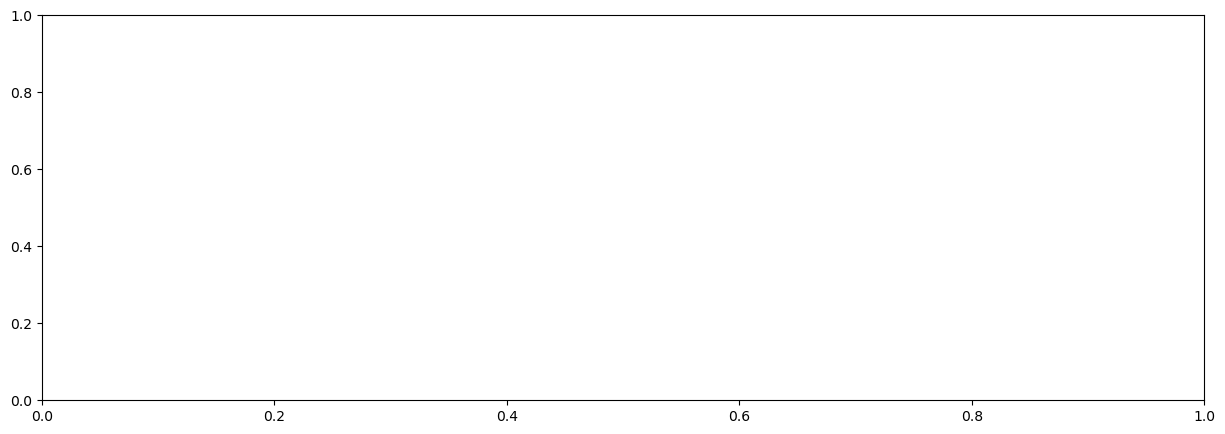

In [761]:
fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(results['heat demand_load'], label='heat demand')
#ax.plot(results['heatpump_thermal_power'] + results['heatpump_electric_power'] - results['heat demand_load'], label='heat pump thermal delivered')
ax.plot(results['heatpump_thermal_power']/results['heatpump_electric_power'], label='cop')
#ax.plot(results['electricity demand_heatpump_load'], label='heat pump electric 2')
#ax.plot(results['heatpump_thermal_power'], label='heat pump thermal')
fig.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(results['heat demand_load'], label='heat demand')
#ax.plot(results['heatpump_thermal_power'] + results['heatpump_electric_power'] - results['heat demand_load'], label='heat pump thermal delivered')
ax.plot(results['heatpump_electric_power'], label='heat pump electric')
#ax.plot(results['electricity demand_heatpump_load'], label='heat pump electric 2')
ax.plot(results['heatpump_thermal_power'], label='heat pump thermal')
fig.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['heatpumpsource_source_flow'], label='heat source flow')
#ax.plot(results['heatpump_thermal_power'] + results['heatpump_electric_power'] - results['heat demand_load'], label='heat pump thermal delivered')
#ax.plot(results['heatpump_electric_power'], label='heat pump electric')
#ax.plot(results['heatpump_thermal_power'], label='heat pump thermal')
fig.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['heatpumpsource_source_flow'], label='heat source flow')
#ax.plot(results['heatpump_thermal_power'] + results['heatpump_electric_power'] - results['heat demand_load'], label='heat pump thermal delivered')
#ax.plot(results['heatpump_electric_power'], label='heat pump electric')
#ax.plot(results['heatpump_thermal_power'], label='heat pump thermal')
fig.legend()

### Electricity

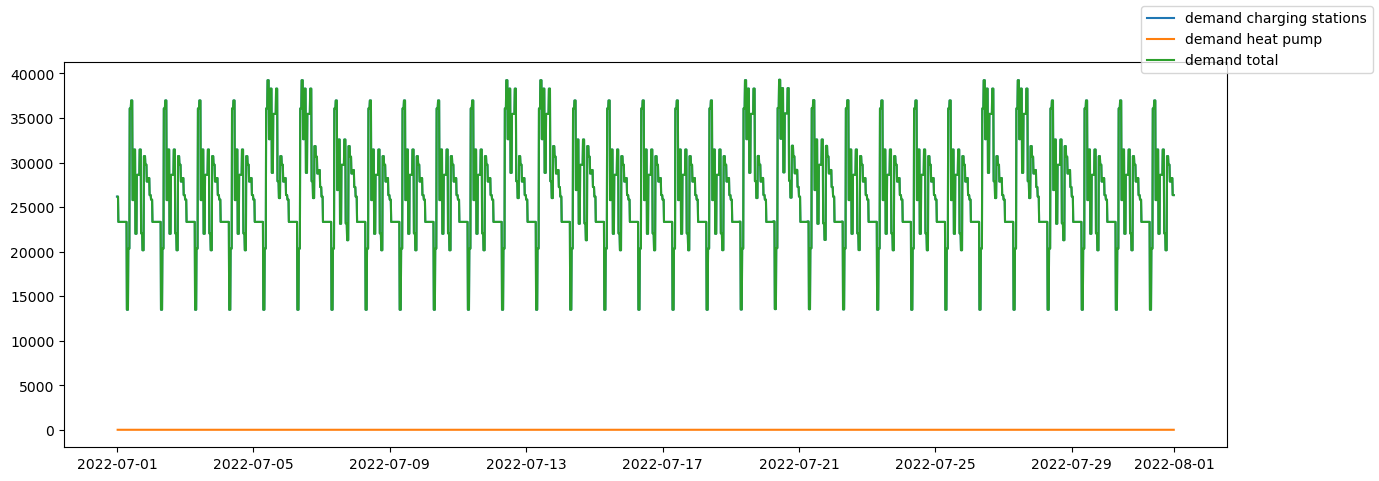

In [761]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['electricity demand_total_load'], label='demand charging stations')
ax.plot(results['electricity demand_heatpump_load'], label='demand heat pump')
ax.plot(results['electricity demand_heatpump_load'] + results['electricity demand_total_load'], 
        label='demand total')
fig.legend()

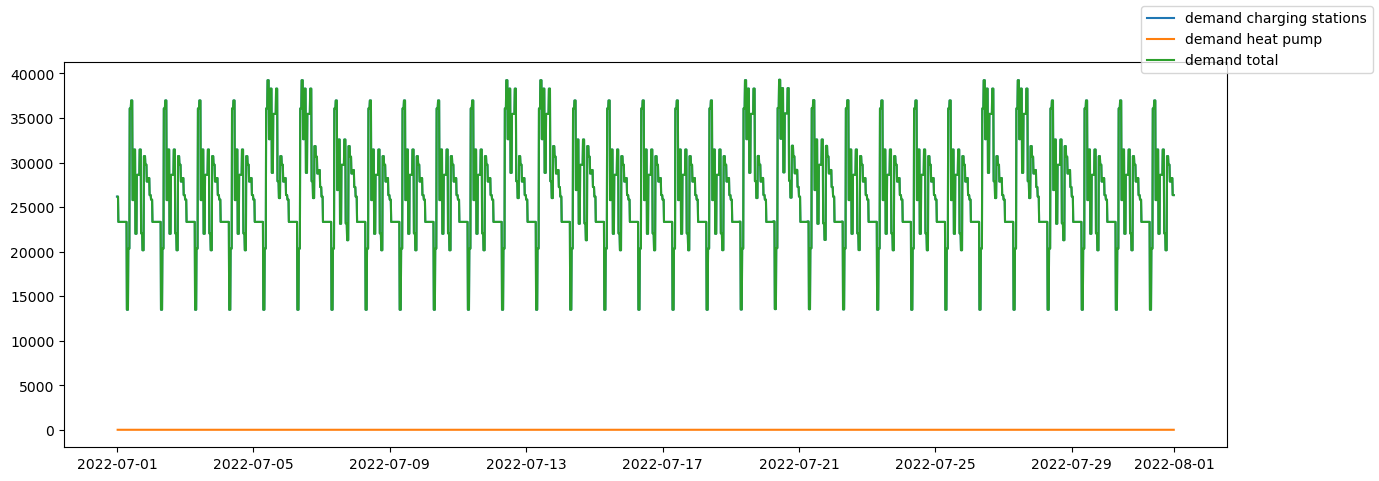

In [762]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['electricity demand_total_load'], label='demand charging stations')
ax.plot(results['electricity demand_heatpump_load'], label='demand heat pump')
ax.plot(results['electricity demand_heatpump_load'] + results['electricity demand_total_load'], 
        label='demand total')
fig.legend()

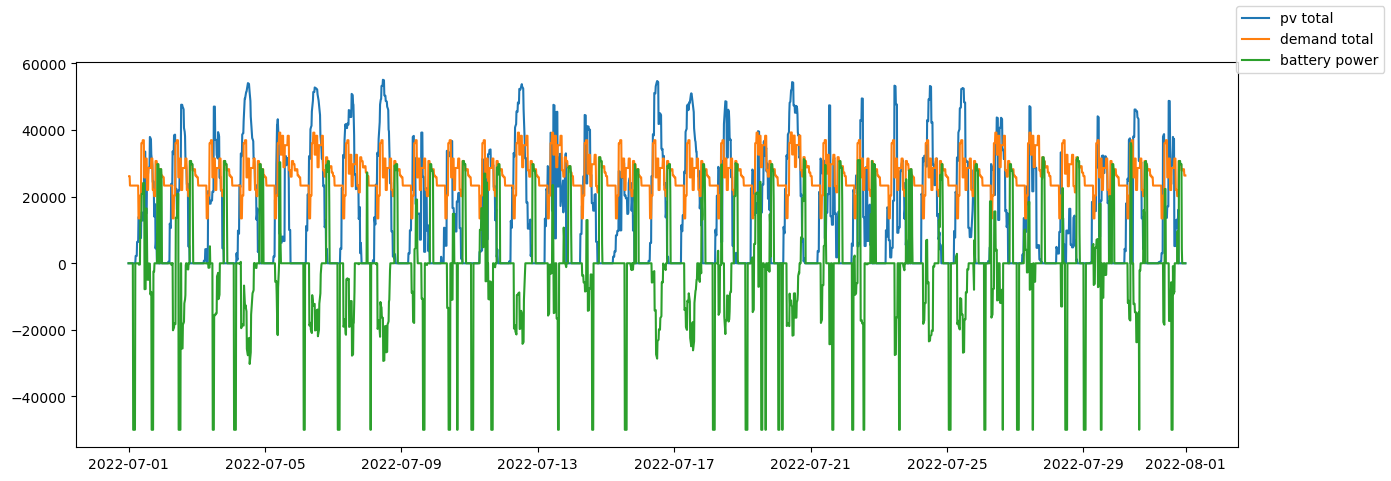

In [763]:
fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(results['pvinstallation east_power'], label='pv east')
#ax.plot(results['pvinstallation south_power'], label='pv south')
#ax.plot(results['pvinstallation west_power'], label='pv west')
ax.plot(results['pvinstallation east_power'] + 
        results['pvinstallation south_power'] + 
        results['pvinstallation west_power'], label='pv total')
ax.plot(results['electricity demand_heatpump_load'] + results['electricity demand_total_load'], 
        label='demand total')
ax.plot(results['battery_power'], label='battery power')
fig.legend()
#ax.set_xlim(datetime.datetime(2022,1,20), datetime.datetime(2022,1,25))

In [818]:
sum(results['pvinstallation east_power'] + results['pvinstallation south_power'] + results['pvinstallation west_power']) / 4

6922623.384286809

In [819]:
sum(results['electricity demand_heatpump_load'] + results['electricity demand_total_load']) / 4

nan

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['price_price']*1e6, label='price')
ax.plot(results['battery_state_of_charge'], label='battery SOC')
ax.plot(results['battery_power']/1000, label='battery power')
#ax.set_xlim(datetime.datetime(2022,1,20), datetime.datetime(2022,1,25))
fig.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(results['background_el_demand_coverage_pv'], label='pv')
ax.plot(results['background_el_demand_coverage_pv'] + results['background_el_demand_coverage_battery'], 
        label='battery')
ax.plot(results['background_el_demand_coverage_pv'] + results['background_el_demand_coverage_battery'] + 
        results['background_el_demand_coverage_grid'], 
        label='grid')

fig.legend()

## Scenarios

In [764]:
def get_results(simulations, path_to_results_files, battery=True, heat_pump=True):
    simulation_results = []
    for sim in simulations:
        file = os.path.join(path_to_results_files, 
                            f"{simulation_name}_{sim.get('month')}_batt{sim.get('battery_storage')}_pv{sim.get('pv')}_price{sim.get('price')}.csv")
        print(f"Reading and analysing {file}...")
        simulationanalyser = SimulationAnalyser(file)
        sim['simulationanalyser'] = simulationanalyser
        w_to_kwh = ['pvinstallation east_power', 'pvinstallation south_power', 
                    'pvinstallation west_power', 'electricity demand_total_load']
        if heat_pump:
            w_to_kwh.append(['electricity demand_heatpump_load', 'heat demand_load', 
                             'heatpump_electric_power', 'heatpump_thermal_power'])
        simulationanalyser.data[w_to_kwh] = simulationanalyser.data[w_to_kwh] / 4000 # W to kWh
        simulationanalyser.data['price_price'] = simulationanalyser.data['price_price'] * 1000
        if battery:
            simulationanalyser.data['battery_power'] = simulationanalyser.data['battery_power']*-1 / 4000.0 # W to kWh
        sim['total pv'] = simulationanalyser.calculate_total_pv(['pvinstallation east_power',
                                                                       'pvinstallation south_power', 
                                                                       'pvinstallation west_power'])
        sim['total demand'] = simulationanalyser.calculate_total_demand(['electricity demand_total_load',
                                                                         'electricity demand_heatpump_load'])
        sim['selfconsumption pv'] = simulationanalyser.calculate_self_consumption_pv('pv total power',
                                                                                     'eldemand total power')
        if battery:
            sim['total grid demand'] = simulationanalyser.get_total_grid_consumption('pv total power',
                                                                                  'eldemand total power', 
                                                                                  'battery_power')
            sim['selfconsumption'] = simulationanalyser.calculate_self_consumption('pv total power',
                                                                               'battery_power',
                                                                               'eldemand total power')
            sim['battery storage solar'] = simulationanalyser.get_battery_storage_solar('pv total power',
                                                                                        'battery_power',
                                                                                        'eldemand total power')
            sim['battery storage grid'] = simulationanalyser.get_battery_storage_grid('pv total power',
                                                                                      'battery_power',
                                                                                      'eldemand total power')
            sim['total costs'] = simulationanalyser.get_total_costs('pv total power', 
                                                                    'eldemand total power',
                                                                    'price_price',
                                                                    'battery_power')
            sim['total costs no ems'] = sum(simulationanalyser.data['demand costs no ems'])
            sim['total costs battery charging'] = sum(simulationanalyser.data['battery charging costs'])
            sim['total savings'] = simulationanalyser.get_total_savings('pv total power', 
                                                                        'eldemand total power',
                                                                        'price_price', 
                                                                        'battery_power') 
            sim['total savings battery discharging'] = sum(simulationanalyser.data['avoided costs battery'])
            sim['injected'] = simulationanalyser.get_injection('pv total power', 
                                                               'eldemand total power', 
                                                               'battery_state_of_charge')
            sim['injected profit'] = simulationanalyser.get_injection('pv total power', 
                                                                      'eldemand total power', 
                                                                      'battery_state_of_charge',
                                                                      'price_price')
        else:
            sim['total grid demand'] = simulationanalyser.get_total_grid_consumption('pv total power',
                                                                                  'eldemand total power')
            sim['selfconsumption'] = sim['selfconsumption pv']
            sim['total costs'] = simulationanalyser.get_total_costs('pv total power', 
                                                                    'eldemand total power',
                                                                    'price_price')
            sim['total costs no ems'] = sum(simulationanalyser.data['demand costs no ems'])
            sim['total savings'] = simulationanalyser.get_total_savings('pv total power', 
                                                                        'eldemand total power',
                                                                        'price_price') 
            sim['injected'] = simulationanalyser.get_injection('pv total power', 
                                                               'eldemand total power')
            sim['injected profit'] = simulationanalyser.get_injection('pv total power', 
                                                                      'eldemand total power', 
                                                                      'price_price')
        sim['peak grid demand'] = max(simulationanalyser.data['total grid demand'])
        simulation_results.append(sim)
    return simulation_results

In [766]:
path_to_results_files = '/Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/'
simulation_results = get_results(simulations_year2, path_to_results_files, battery=True, heat_pump=False)

Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/technicum_jan_batt83_pv112_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/technicum_feb_batt83_pv112_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/technicum_mar_batt83_pv112_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/technicum_apr_batt83_pv112_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/technicum_may_batt83_pv112_price2022.csv...
Reading and analysing /Users/chaimdemulder/Documents/DuCoop_OpenMotics/EnerMotics/Projecten/Technicum/SimulationResults/year2/technicum_jun_batt83_pv1

In [767]:
pd.DataFrame(simulation_results).to_csv('./technicum_simulation_results_year_2.csv')

In [ ]:
battery_comparison_winter = []
battery_comparison_spring = []
battery_comparison_summer = []
for sim in simulations:
    if sim.get('pv') == 150 and sim.get('price') == 2022 and sim.get('month') == 'jan':
        battery_comparison_winter.append(sim)
    if sim.get('pv') == 150 and sim.get('price') == 2022 and sim.get('month') == 'apr':
        battery_comparison_spring.append(sim)
    if sim.get('pv') == 150 and sim.get('price') == 2022 and sim.get('month') == 'jul':
        battery_comparison_summer.append(sim)
        
pv_comparison_winter = []
pv_comparison_spring = []
pv_comparison_summer = []
for sim in simulations:
    if sim.get('battery_storage') == 250 and sim.get('price') == 2022 and sim.get('month') == 'jan':
        pv_comparison_winter.append(sim)
    if sim.get('battery_storage') == 250 and sim.get('price') == 2022 and sim.get('month') == 'apr':
        pv_comparison_spring.append(sim)
    if sim.get('battery_storage') == 250 and sim.get('price') == 2022 and sim.get('month') == 'jul':
        pv_comparison_summer.append(sim)

price_comparison_winter = []
price_comparison_spring = []
price_comparison_summer = []
for sim in simulations:
    if sim.get('battery_storage') == 250 and sim.get('pv') == 150 and sim.get('month') == 'jan':
        price_comparison_winter.append(sim)
    if sim.get('battery_storage') == 250 and sim.get('pv') == 150 and sim.get('month') == 'apr':
        price_comparison_spring.append(sim)
    if sim.get('battery_storage') == 250 and sim.get('pv') == 150 and sim.get('month') == 'jul':
        price_comparison_summer.append(sim)

### Battery storage

In [ ]:
parameter = 'total savings'
width = 20
fig, ax = plt.subplots()
ax.bar([x.get('battery_storage') - 30 for x in battery_comparison_winter],
       [x.get(parameter) for x in battery_comparison_winter],
       #tick_label=[str(x.get('battery_storage')) for x in battery_comparison_winter],
      width=width, label='Winter')
ax.bar([x.get('battery_storage') - 10 for x in battery_comparison_spring],
       [x.get(parameter) for x in battery_comparison_spring],
       tick_label=[str(x.get('battery_storage')) for x in battery_comparison_spring],
      width=width, label='Spring')
ax.bar([x.get('battery_storage') + 10 for x in battery_comparison_summer],
       [x.get(parameter) for x in battery_comparison_summer],
       tick_label=[str(x.get('battery_storage')) for x in battery_comparison_winter],
      width=width, label='Summer')
ax.set_xlabel('Battery capacity [kWh]')
ax.set_ylabel(parameter)
fig.legend()
#ax.set_xticklabels([str(x.get('battery_storage')) for x in battery_comparison_winter])
sns.despine()

### PV

In [ ]:
width = 10
parameter = 'total savings'
fig, ax = plt.subplots()
ax.bar([x.get('pv') - 15 for x in pv_comparison_winter],
       [x.get(parameter) for x in pv_comparison_winter],
       #tick_label=[str(x.get('battery_storage')) for x in battery_comparison_winter],
      width=width, label='Winter')
ax.bar([x.get('pv') - 5 for x in pv_comparison_spring],
       [x.get(parameter) for x in pv_comparison_spring],
       #tick_label=[str(x.get('battery_storage')) for x in battery_comparison_winter],
      width=width, label='Spring')
ax.bar([x.get('pv') + 5 for x in pv_comparison_summer],
       [x.get(parameter) for x in pv_comparison_summer],
       tick_label=[str(x.get('pv')) for x in pv_comparison_summer],
      width=width, label='Summer')
ax.set_xlabel('PV capacity [kWp]')
ax.set_ylabel(parameter)
fig.legend()
#ax.set_xticklabels([str(x.get('battery_storage')) for x in battery_comparison_winter])
sns.despine()

### Price

In [ ]:
width = 0.05
parameter = 'total savings'
fig, ax = plt.subplots()
ax.bar([x.get('price') - 0.05 for x in price_comparison_winter],
       [x.get(parameter) for x in price_comparison_winter],
       #tick_label=[str(x.get('battery_storage')) for x in battery_comparison_winter],
      width=width, label='Winter')
ax.bar([x.get('price') for x in price_comparison_spring],
       [x.get(parameter) for x in price_comparison_spring],
       #tick_label=[str(x.get('battery_storage')) for x in battery_comparison_winter],
      width=width, label='Spring')
ax.bar([x.get('price') + 0.05 for x in price_comparison_summer],
       [x.get(parameter) for x in price_comparison_summer],
       tick_label=[str(x.get('price')) for x in price_comparison_summer],
      width=width, label='Summer')
ax.set_xlabel('Price year')
ax.set_ylabel(parameter)
fig.legend()
#ax.set_xticklabels([str(x.get('battery_storage')) for x in battery_comparison_winter])
sns.despine()

### Heatmaps

In [ ]:
pvs = list(set([float(sim.get('pv')) for sim in simulations]))
pvs.sort()
batterys = list(set([float(sim.get('battery_storage')) for sim in simulations]))
batterys.sort(reverse=True)
scenarios = {'jan': pd.DataFrame(columns=pvs, index=batterys, dtype=float),
             'apr': pd.DataFrame(columns=pvs, index=batterys, dtype=float),
             'jul': pd.DataFrame(columns=pvs, index=batterys, dtype=float)}

In [ ]:
parameter = 'selfconsumption'
for sim in simulations:
    if sim.get('price') == 2021:
        continue
    scenarios[sim.get('month')].loc[sim.get('battery_storage'), sim.get('pv')] = float(sim.get(parameter))

In [ ]:
fig = sns.heatmap(scenarios['jan'], annot=True, cmap=sns.color_palette("viridis", as_cmap=True))
fig.set(title='Self-consumption in January [k€]', xlabel='PV capacity [kWp]', ylabel='Battery capacity [kWh]')

In [ ]:
fig = sns.heatmap(scenarios['jul'], annot=True, cmap=sns.color_palette("viridis", as_cmap=True))
fig.set(title='Self-consumption in July [k€]', xlabel='PV capacity [kWp]', ylabel='Battery capacity [kWh]')

In [ ]:
fig = sns.heatmap(scenarios['apr'], annot=True, cmap=sns.color_palette("viridis", as_cmap=True))
fig.set(title='Self-consumption in April [k€]', xlabel='PV capacity [kWp]', ylabel='Battery capacity [kWh]')

In [ ]:
simulations[0].get('simulationanalyser').calculate_total_pv(['pvinstallation east_power',
                                                             'pvinstallation south_power', 
                                                             'pvinstallation west_power'])

In [ ]:
simulations[0].get('simulationanalyser').calculate_self_consumption_pv(pv_column_name='pv total power',
                                                                       demand_column_name='electricity demand_total_load')

In [ ]:
simulations[0].get('simulationanalyser').calculate_self_consumption(pv_column_name='pv total power',
                                                                    battery_column_name='battery_power',
                                                                       demand_column_name='electricity demand_total_load')

In [ ]:
sum(simulations[0].get('simulationanalyser').data['selfconsumption'] * \
simulations[0].get('simulationanalyser').data['electricity demand_total_load']) / sum(simulations[0].get('simulationanalyser').data['electricity demand_total_load'])

In [799]:
price = pd.read_csv(price_data, index_col='Time', parse_dates=True)

In [802]:
price_monthly = price.resample('M').mean()

In [846]:
months = ['jan', 'feb', 'mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
selfconsumption_pv = [5.0,8.4,20.3,38.3,41.6,41.2,42.8,41.8,30.1,18.9,9.8,5.0]
selfconsumption = [10.5,16.7,29.7,48.4,52.0,52.1,54.9,52.9,43.4,30.1,17.0,9.6]
savings = [1614,1532,2398,2562,2425,2773,3793,5103,3207,1687,1546,1763]
payback_time = [7.044102335,7.42049939,4.740156588,4.437213683,4.687624804,4.099349696,
                2.99710657,2.227560115,3.545276382,6.740063331,7.35526074,6.4487977]
monthly_cost = 757.9

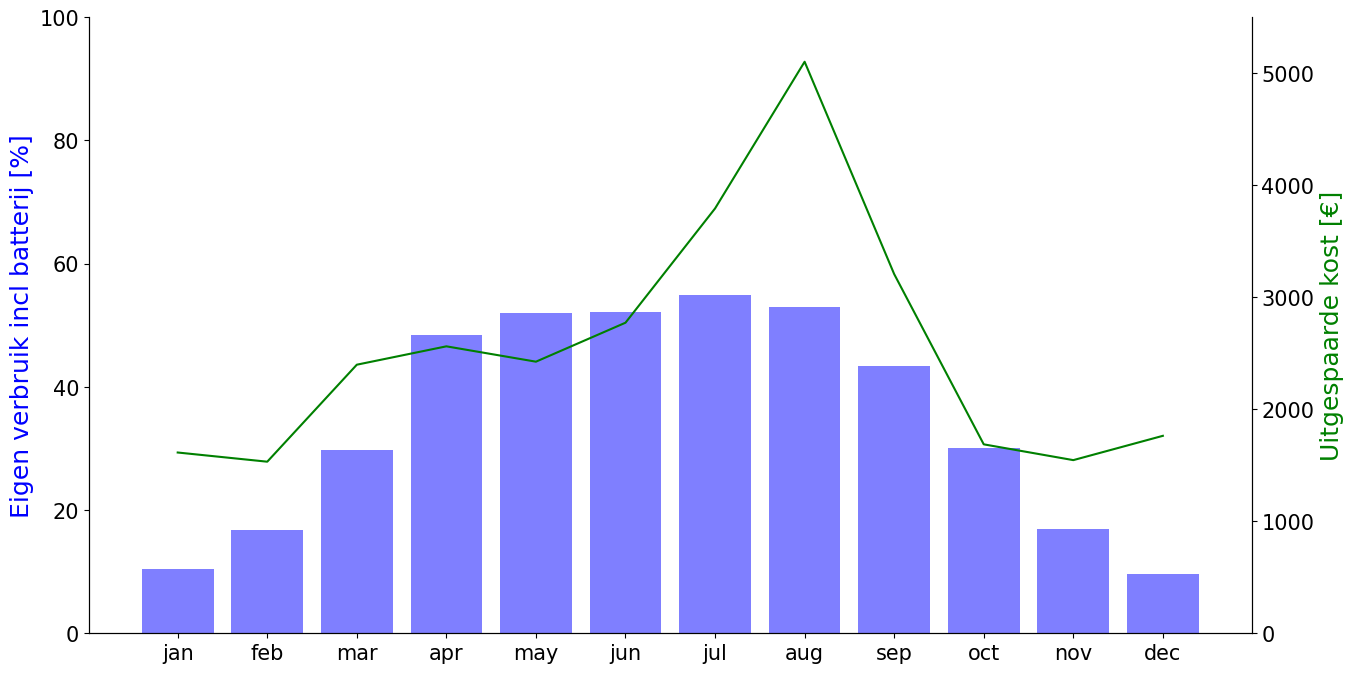

In [835]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(months, selfconsumption, label='Eigen verbruik incl batterij', color='b', alpha=0.5)
ax.set_ylim(0, 100)
ax.tick_params(labelsize=15)
ax.set_ylabel('Eigen verbruik incl batterij [%]', fontsize=18, color='b')

ax2 = ax.twinx()
ax2.plot(months, savings, label='Uitgespaarde kost', color='g')
ax2.set_ylim(0,5500)
ax2.tick_params(labelsize=15)
ax2.set_ylabel('Uitgespaarde kost [€]', fontsize=18, color='g')
#fig.legend(fontsize=15)
sns.despine(right=False)

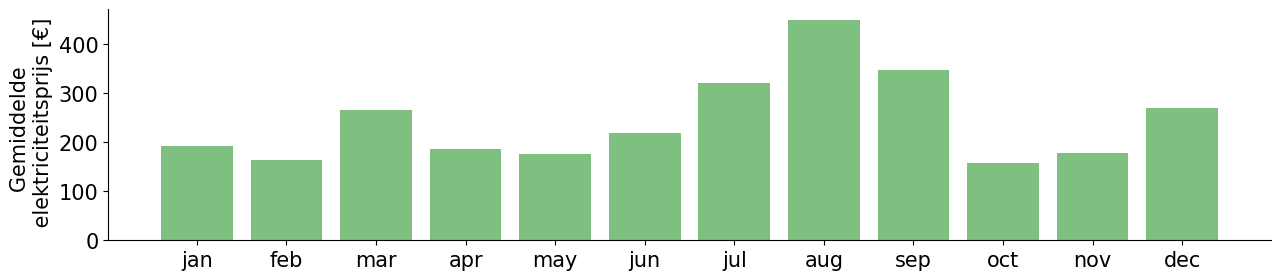

In [821]:
fix, ax = plt.subplots(figsize=(15,3))
ax.bar(months, price_monthly['price'], color='g', alpha=0.5)
ax.tick_params(labelsize=15)
ax.set_ylabel('Gemiddelde \n elektriciteitsprijs [€]', fontsize=15)
sns.despine()

In [828]:
[i - j for i, j in zip(selfconsumption, selfconsumption_pv)]

[5.5,
 8.299999999999999,
 9.399999999999999,
 10.100000000000001,
 10.399999999999999,
 10.899999999999999,
 12.100000000000001,
 11.100000000000001,
 13.299999999999997,
 11.200000000000003,
 7.199999999999999,
 4.6]

In [854]:
price_monthly['price']

Time
2022-01-31    191.409422
2022-02-28    162.618657
2022-03-31    265.950973
2022-04-30    186.598569
2022-05-31    176.642083
2022-06-30    219.105028
2022-07-31    321.349597
2022-08-31    448.152016
2022-09-30    346.504986
2022-10-31    157.386698
2022-11-30    177.905258
2022-12-31    269.277621
Freq: M, Name: price, dtype: float64

In [842]:
payback_time

[7.044102335,
 7.42049939,
 4.740156588,
 4.437213683,
 4.687624804,
 4.099349696,
 2.99710657,
 2.227560115,
 3.545276382,
 6.740063331,
 7.35526074,
 6.4487977]

In [847]:
savings_corrected = savings / price_monthly['price'] * 100 # with 100 the current average price

In [850]:
(15 / (savings_corrected / monthly_cost)).mean()

11.387747105534265